We hypothesise that there will be two significant peaks in the greyscale intesity of the CT scans, due to edge effects: these will be at the boundary between air and the cementum, and at the cementum-dentine boundary.

To check this we will find 4 random images from 4 teeth, straighten them and plot the greyscale intensity along each row. Hopefully we will see these two peaks.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Choose an image to demonstrate with

"""

import os
import numpy as np


def paths(i: int) -> tuple[str, str]:
    """Image and Mask path from an index"""
    rvs = f"data/original cut/{i:04d}.tif", f"data/masks cut/{i:04d}.tif"
    for path in rvs:
        assert os.path.exists(path), path

    return rvs


index = 5
img_path, mask_path = paths(index)

img_path, mask_path

('data/original cut/0005.tif', 'data/masks cut/0005.tif')

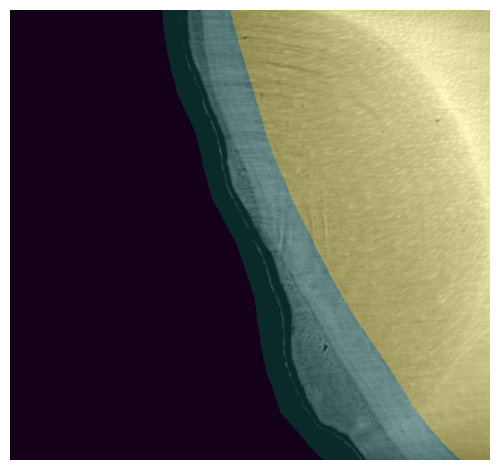

In [3]:
"""
Display it

"""

import matplotlib.pyplot as plt

fig, axis = plt.subplots()

img = plt.imread(img_path)
mask = plt.imread(mask_path)

axis.imshow(img, cmap="gray")
axis.imshow(mask, alpha=0.3)

axis.set_axis_off()

imgdir = f"img/detect_cementum/{index}/"
if not os.path.isdir(imgdir):
    os.makedirs(imgdir)

fig.tight_layout()
fig.savefig(f"{imgdir}/img_masks.png", bbox_inches="tight")

/home/mh19137/cementum/cementum/straighten.py:527: UserWarning: Temporary solution: removing 103 saturated columns from right
  warnings.warn(
/home/mh19137/cementum/cementum/straighten.py:553: UserWarning: Temporary solution: removing 101 zero rows from bottom
  warnings.warn(


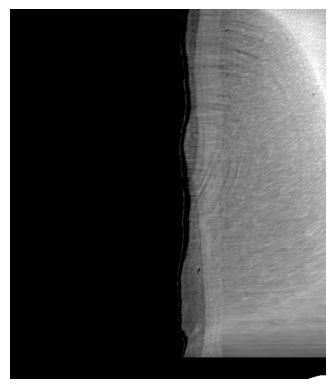

In [4]:
"""
Straighten these images according the the masks

"""

from cementum import straighten

n_y = 20
n_left, n_x, n_right = 5, 5, 5

fig, axis = plt.subplots()

# Define two grids of points that will we use to perform our straightening
curve_pts = straighten.mask_mesh(mask, n_y, (n_left, n_x, n_right))
straight_pts = straighten.straight_mesh(mask, n_y, (n_left, n_x, n_right))

# Straighten the image
img = plt.imread(img_path)
straight_image = straighten.apply_transformation(img, curve_pts, straight_pts)

# Straighten the mask
straight_mask = straighten.apply_transformation(mask, curve_pts, straight_pts)

# Remove the white columns from the image and the corresponding columns from the mask
straight_image, straight_mask = straighten.remove_white_cols(
    straight_image, straight_mask
)

# Remove padding
straight_image = straighten.remove_padding(straight_image)
straight_mask = straighten.remove_padding(straight_mask)


# Display it
axis.imshow(straight_image, cmap="gray")
axis.set_axis_off()

fig.savefig(f"{imgdir}/straightened.png", bbox_inches="tight")

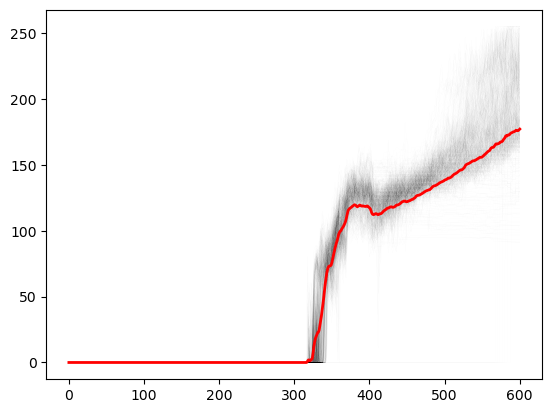

In [5]:
"""
Plot the greyscale intensity across each row for all of these images

"""

fig, axis = plt.subplots()

intensity_profile = np.mean(straight_image, axis=0)

for row in straight_image:
    axis.plot(row, alpha=0.05, linewidth=0.05, color="k")
axis.plot(intensity_profile, color="r", linewidth=2)

fig.savefig(f"{imgdir}/intensity.png", bbox_inches="tight")

 93%|█████████▎| 171/184 [01:18<00:05,  2.19it/s]


50
50
saving img/detect_cementum/5//anim/animation.mp4
50
50


53
56


59
62


65
68


71
74


77
80


83
86


89
92


95
98


101
104


107
110


113
116


119
122


125
128


131
134


137
140


143
146


149
152


155
158


161
164


167
170


173
176


179
182


185
188


191
194


197


200


203
206


209
212


215
218


 33%|███▎      | 60/184 [00:09<00:20,  6.03it/s]

221
224


227
230


233
236


239
242


245
248


251
254



 40%|████      | 74/184 [00:11<00:16,  6.55it/s]

257
260


263
266


269
272


275
278


281
284


287
290


293
296


299
302


305
308


311


314
317


320
323


326
329


 53%|█████▎    | 97/184 [00:15<00:14,  6.21it/s]

332
335


338
341


344


347
350


353
356


359
362


365
368


371
374


377
380


383
386


389
392


395
398


401
404


407
410


413
416


419
422


425
428


431
434


437
440


443
446


449
452


455
458


461
464


467
470


473


476
479


482
485


488
491


494


497
500


503
506


509
512


515


518


521
524


527


530
533


536
539


542
545


548
551


554
557


560
563


566
569


572
575


578
581


584
587


590
593


596


599
img/detect_cementum/5/detection.png


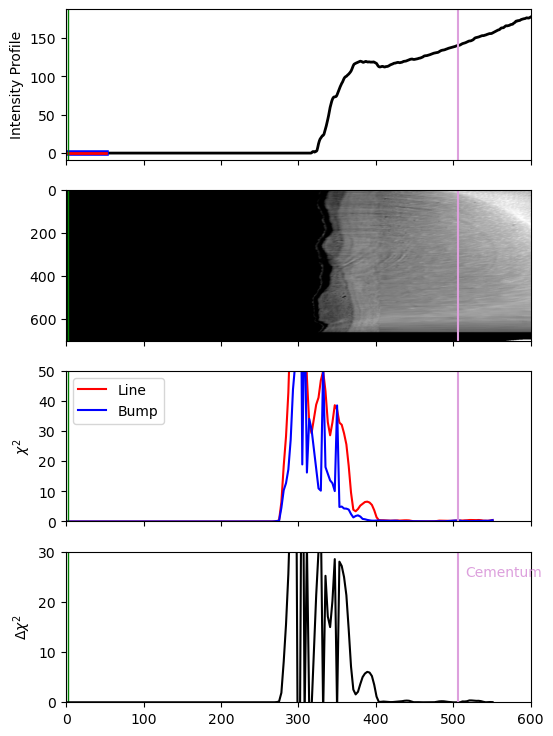

In [10]:
"""
Gif showing the fit process

"""

from matplotlib.animation import FuncAnimation
from tqdm import tqdm

from cementum import fit_cementum

assert len(intensity_profile) == straight_image.shape[1]

# Fit params
domain_length = 50

# Peak detection params
tolerance = 7
rel_height = 0.99

fig, axes = plt.subplots(4, 1, figsize=(6, 9), sharex=True)

# Show the intensity profile and image
axes[0].plot(
    np.arange(len(intensity_profile)), intensity_profile, color="k", linewidth=2
)
axes[1].imshow(straight_image, cmap="gray", aspect="auto")

axes[2].set_ylim((0, 50))
axes[3].set_ylim((0, 30))

# Offsets from the right edge of the image
offsets = np.arange(domain_length, len(intensity_profile), 3)

# Do one fit
line_params, line_chi2, line_x = fit_cementum.fit_line_restricted_domain(
    offsets[0], intensity_profile, n_pixels=domain_length
)
bump_params, bump_chi2, bump_x = fit_cementum.fit_line_with_bump_restricted_domain(
    offsets[0], intensity_profile, n_pixels=domain_length
)

assert (bump_x == line_x).all()
leftmost_points = [line_x.min()]

line_chi2s = [line_chi2]
bump_chi2s = [bump_chi2]

# Show the fits
(bump_line,) = axes[0].plot(
    bump_x,
    fit_cementum.line_with_bump(bump_x, *bump_params),
    "b",
    linewidth=4,
)
(fit_line,) = axes[0].plot(
    line_x,
    fit_cementum._line(line_x, *line_params),
    "r",
    linewidth=2,
)

# goodness of fits
(line_chi2_line,) = axes[2].plot(leftmost_points, line_chi2s, "-r", label="Line")
(bump_chi2_line,) = axes[2].plot(leftmost_points, bump_chi2s, "-b", label="Bump")

# Vertical lines tracking where we are
vlines = [axis.axvline(leftmost_points[-1], color="g", linewidth=1) for axis in axes]

# Delta Chi2
delta_chi2 = [line_chi2 - bump_chi2]
(delta_chi2_line,) = axes[3].plot(leftmost_points, delta_chi2, "-k", label="Delta Chi2")

# Progress bar
pbar = tqdm(total=len(offsets))


# Animation
def update_lines(offset):
    """
    Perform another fit and update the lines

    """
    global pbar

    # Re do fits
    print(offset)
    line_params, line_chi2, line_x = fit_cementum.fit_line_restricted_domain(
        offset, intensity_profile, n_pixels=domain_length
    )
    bump_params, bump_chi2, bump_x = fit_cementum.fit_line_with_bump_restricted_domain(
        offset, intensity_profile, n_pixels=domain_length
    )

    # Update fit lines
    assert (line_x == bump_x).all()
    leftmost_points.append(line_x.min())
    fit_line.set_data(line_x, fit_cementum._line(line_x, *line_params))
    bump_line.set_data(bump_x, fit_cementum.line_with_bump(bump_x, *bump_params))

    # Update chi2 lines
    line_chi2s.append(line_chi2)
    bump_chi2s.append(bump_chi2)
    line_chi2_line.set_data(leftmost_points, line_chi2s)
    bump_chi2_line.set_data(leftmost_points, bump_chi2s)

    delta_chi2.append(line_chi2 - bump_chi2)
    delta_chi2_line.set_data(leftmost_points, delta_chi2)

    # Update vertical lines
    for line in vlines:
        line.set_data([leftmost_points[-1], leftmost_points[-1]], line.get_ydata())

    pbar.update(1)

    return fit_line, bump_line, line_chi2_line, bump_chi2_line, delta_chi2_line, *vlines


anim = FuncAnimation(
    fig,
    update_lines,
    frames=offsets,
    fargs=(),
    interval=30,
    blit=True,
)

axes[0].set_ylabel("Intensity Profile")
axes[2].legend()
axes[2].set_ylabel(r"$\chi^2$")
axes[3].set_ylabel(r"$\Delta\chi^2$")

anim_dir = f"{imgdir}/anim"
if not os.path.isdir(anim_dir):
    os.mkdir(anim_dir)

path = f"{anim_dir}/animation.mp4"
print(f"saving {path}")
anim.save(path)

# Detect the cementum peak, plot + save it
peak_location = fit_cementum.find_cementum(
    leftmost_points, delta_chi2, tolerance=tolerance, rel_height=1.0
)
for axis in axes:
    axis.axvline(peak_location, color="plum")

axes[3].text(peak_location + 10, 25, "Cementum", color="plum")
path = f"{imgdir}detection.png"
print(path)
fig.savefig(path, bbox_inches="tight")

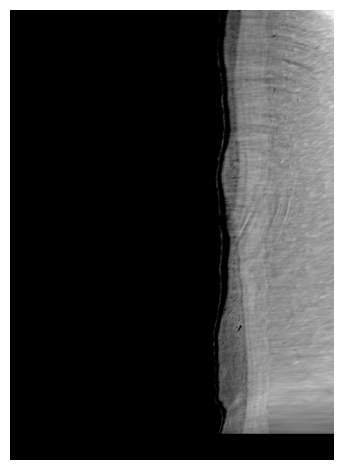

In [11]:
"""
Crop the cementum out

"""

cropped_img = straight_image[:, :peak_location]

fig, axis = plt.subplots()
axis.imshow(cropped_img, cmap="gray")
axis.set_axis_off()

fig.tight_layout()
fig.savefig(f"{imgdir}/cropped.png", bbox_inches="tight")

This next cell will save the output as `cropped_image.npy`, just so that I can load it quickly in future notebooks

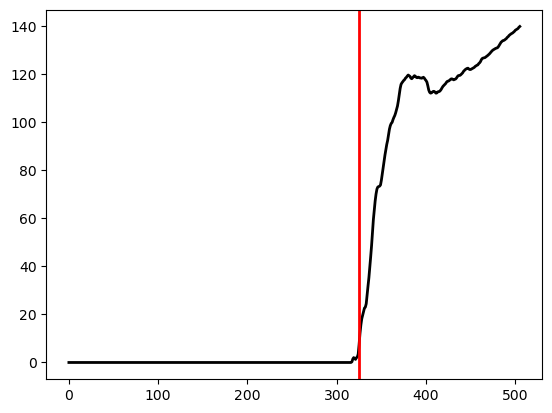

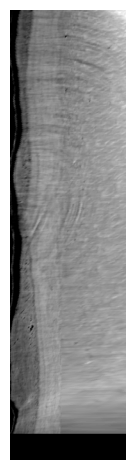

In [12]:
"""
Find the left edge of the cementum...

"""

import ruptures as rpt

mean = np.mean(cropped_img, axis=0)

edge, *_ = rpt.Binseg(model="l1").fit(mean).predict(pen=10)

fig, axis = plt.subplots()

axis.plot(mean, color="k", linewidth=2)
axis.axvline(edge, color="r", linewidth=2)

fig, axis = plt.subplots()
cropped_img = cropped_img[:, edge:]
axis.imshow(cropped_img, cmap="gray")
axis.set_axis_off()
fig.tight_layout()
fig.savefig(f"{imgdir}/double_cropped.png", bbox_inches="tight")

np.save("cropped_image.npy", cropped_img)

Let's now try it on multiple images, to make sure it's at least a little robust

In [13]:
"""
Choose a few images

"""

rng = np.random.default_rng(seed=0)

# Choose some images
n_imgs = 9
n_total = 315  # Total number we have in the dir

indices = rng.integers(0, n_total, n_imgs)
img_paths, mask_paths = zip(*[paths(i) for i in indices])
indices

array([267, 200, 161,  84,  96,  12,  23,   5,  55])

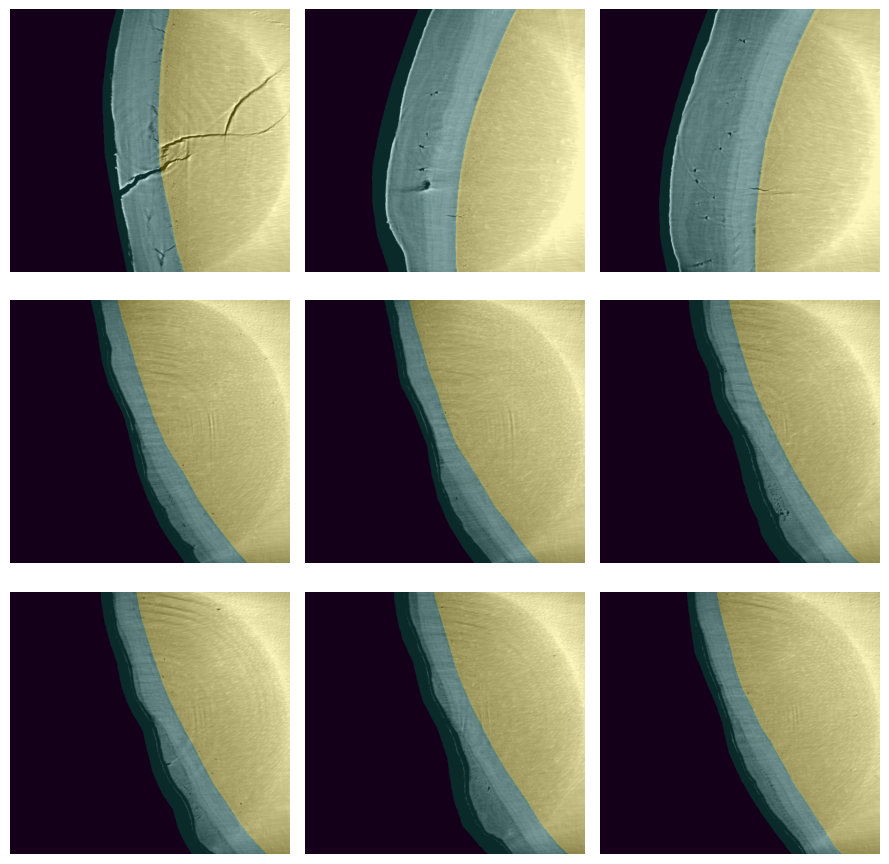

In [14]:
n_row, n_col = 3, 3
assert n_row * n_col == n_imgs

fig, axes = plt.subplots(n_row, n_col, figsize=(9, 9))

imgs = [plt.imread(path) for path in img_paths]
masks = [plt.imread(path) for path in mask_paths]

for axis, img, mask in zip(axes.flat, imgs, masks):
    axis.imshow(img, cmap="gray")
    axis.imshow(mask, alpha=0.3)

    axis.set_axis_off()

fig.tight_layout()

In [15]:
"""
Straighten them

"""

straight_imgs = []

for img, mask, index in zip(imgs, masks, indices):
    # Define two grids of points that will we use to perform our straightening
    try:
        curve_pts = straighten.mask_mesh(mask, n_y, (n_left, n_x, n_right))
        straight_pts = straighten.straight_mesh(mask, n_y, (n_left, n_x, n_right))
    except AssertionError as e:
        print(f"Failed to straighten {index}: {e}")
        raise e

    # Straighten the image
    straight_image = straighten.apply_transformation(img, curve_pts, straight_pts)

    # Remove the white columns from the image and the corresponding columns from the mask
    straight_image, _ = straighten.remove_white_cols(straight_image, straight_image)

    # Remove padding
    straight_image = straighten.remove_padding(straight_image)

    straight_imgs.append(straight_image)

/home/mh19137/cementum/cementum/straighten.py:527: UserWarning: Temporary solution: removing 25 saturated columns from right
  warnings.warn(
/home/mh19137/cementum/cementum/straighten.py:553: UserWarning: Temporary solution: removing 23 zero rows from bottom
  warnings.warn(
/home/mh19137/cementum/cementum/straighten.py:527: UserWarning: Temporary solution: removing 50 saturated columns from right
  warnings.warn(
/home/mh19137/cementum/cementum/straighten.py:553: UserWarning: Temporary solution: removing 13 zero rows from bottom
  warnings.warn(
/home/mh19137/cementum/cementum/straighten.py:527: UserWarning: Temporary solution: removing 47 saturated columns from right
  warnings.warn(
/home/mh19137/cementum/cementum/straighten.py:553: UserWarning: Temporary solution: removing 10 zero rows from bottom
  warnings.warn(
/home/mh19137/cementum/cementum/straighten.py:527: UserWarning: Temporary solution: removing 99 saturated columns from right
  warnings.warn(
/home/mh19137/cementum/ceme

Some of the black rows at the bottom of the image might contain white pixels, so they've not been discarded...

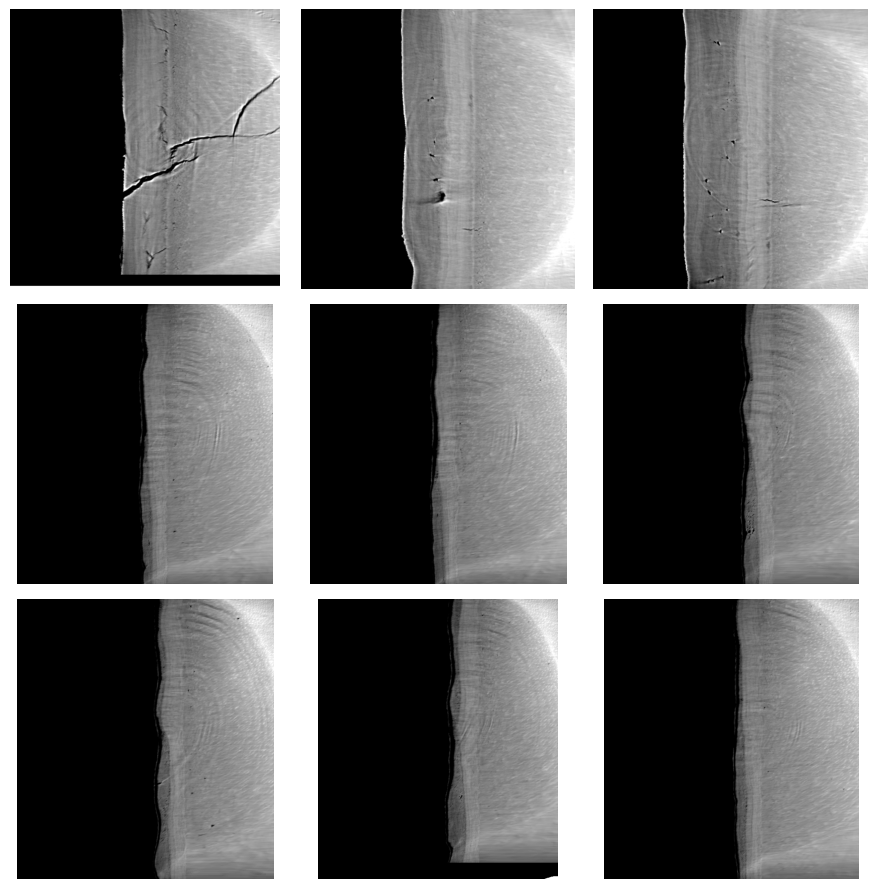

In [16]:
fig, axes = plt.subplots(n_row, n_col, figsize=(9, 9))

for axis, straight_img in zip(axes.flat, straight_imgs):
    axis.imshow(straight_img, cmap="gray")
    axis.set_axis_off()

fig.tight_layout()

.........


/home/mh19137/miniforge3/envs/tf2/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/mh19137/cementum/cementum/fit_cementum.py:287: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(util.coloured(e, util.bcolours.WARNING))


AssertionError: Slice goes out of bounds, end=604

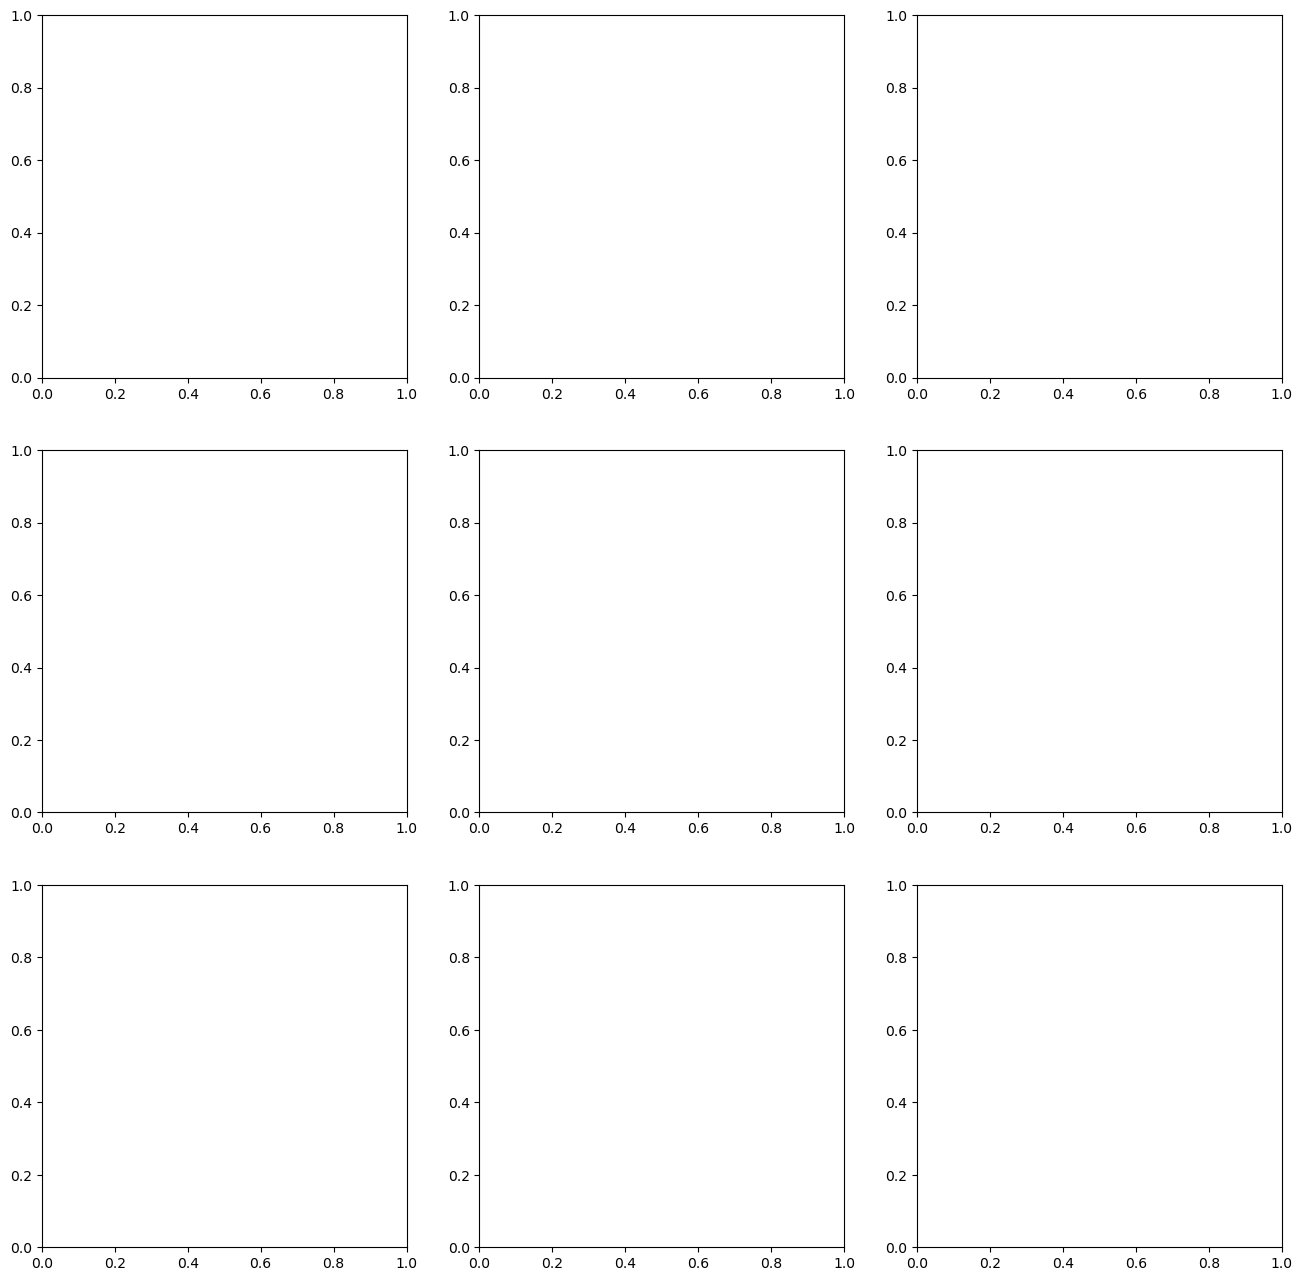

In [17]:
"""
Run fits to find the cementum-dentin boundary

"""

fig, axes = plt.subplots(n_row, n_col, figsize=(16, 16))
locations = []

print("." * n_imgs)
for axis, straight_img, index in zip(axes.flat, straight_imgs, indices):
    intensity_profile = np.mean(straight_img, axis=0)

    peak_location, fit_starts, deltachi2 = fit_cementum.find_boundary(
        intensity_profile, domain_length=50, return_more=True
    )

    axis.plot(intensity_profile, color="r", linewidth=2)

    # Plot delta chi2 as well
    ax2 = axis.twinx()
    ax2.plot(fit_starts, deltachi2, color="k", label=r"$\Delta\chi^2$")
    ax2.set_axis_off()

    axis.axvline(peak_location, color="plum")

    axis.set_title(index)

    locations.append(peak_location)
    print(".", end="", flush=True)

In [ ]:
"""
Crop out the background + cementum

"""